In [255]:
%cd ../Documents/FIA-MS/20200618_Source_Scanrange_Waste_Solvents_Adducts/

[Errno 2] No such file or directory: '../Documents/FIA-MS/20200618_Source_Scanrange_Waste_Solvents_Adducts/'
/Users/matmat/Documents/GitHub/FIA-MS


## Analysis on FIA-MS data after SmartPeak processing
#### This script is based on the assumption that mass ranges and pos/neg have already been merged. Triplicates will be taken care of by only keeping metabolites that were detected in all three of them.

#### Blanks have not fully been taken care of as of yet, they're just processed like regular runs

#### Imports (a bit excessive but did not weed out the important ones yet

In [256]:
import pymzml
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import statistics
import csv
import pickle
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import copy

import matplotlib.colors
from matplotlib_venn import venn3, venn3_circles, venn2, venn2_circles
from mpl_toolkits.mplot3d import Axes3D

from pandas.errors import EmptyDataError

import seaborn as sns
from collections import defaultdict

import xml.etree.ElementTree as ET

from pyopenms import *


## Process HMDB entries from file

In [257]:
HMDB2StructMapping = pd.read_csv("/Users/matmat/Documents/FIA-MS/20200618_Source_Scanrange_Waste_Solvents_Adducts/CHEMISTRY/HMDB2StructMapping.tsv", 
                                 sep="\t", header=None)

In [258]:
SerumTop10 = pd.read_csv("/Users/matmat/Documents/FIA-MS/20200618_Source_Scanrange_Waste_Solvents_Adducts/traML.csv", 
                                 sep="\,", header=None, engine='python')
SerumTop10 = list(SerumTop10.iloc[:,0])[1:]

# Functions

In [259]:
def extract_names_and_intensity(path_to_featureXML_dir, database_name_array):
    wd = path_to_featureXML_dir
    
    filenames_list = []
    for (dirpath, dirnames, filenames) in os.walk(wd):
        filenames_list.extend(filenames)
        break
    sorted_filenames_list = sorted(filenames_list)
    
    timestep_alldata = {}
    for file in sorted_filenames_list:
        features = FeatureMap()
        FeatureXMLFile().load(wd + "/" + file, features)
        extracted_data = {}
        for f in features:
            if f.getMetaValue("PeptideRef").decode("utf-8") in database_name_array:
                extracted_data[f.getMetaValue("PeptideRef").decode("utf-8")] = (f.getMetaValue("peak_apex_int"))
        extracted_data_df = pd.DataFrame(extracted_data.items(), columns=['Metabolite', 'Intensity'])
        timestep_alldata[file] = extracted_data_df
    
    return timestep_alldata

In [260]:
def calculate_mean_and_variance(extracted_info, txt_output_name):
    stats_of_files = {}
    for file_n in range(0, len(extracted_info), 3):
        stats_of_compound = pd.DataFrame(columns = ['Metabolite', 'Mean', 'Variance'])
        file = list(extracted_info.items())
        for metabolite_n in range(0, len(file[file_n][1])):
            if file[file_n][1]['Metabolite'][metabolite_n] in \
            list(file[file_n + 1][1]['Metabolite']) and \
            file[file_n][1]['Metabolite'][metabolite_n] in \
            list(file[file_n + 2][1]['Metabolite']):
                file_1 = file[file_n][1]
                file_2 = file[file_n + 1][1]
                file_3 =  file[file_n + 2][1]

                index_2 = list(file_2['Metabolite']).index(file_1['Metabolite'][metabolite_n])
                index_3 = list(file_3['Metabolite']).index(file_1['Metabolite'][metabolite_n])
                mean_of_compound = statistics.mean([file_1['Intensity'][metabolite_n],\
                                                  file_2['Intensity'][index_2],\
                                                  file_3['Intensity'][index_3]])
                variance_of_compound = statistics.variance([file_1['Intensity'][metabolite_n],\
                                                           file_2['Intensity'][index_2],\
                                                           file_3['Intensity'][index_3]])
                stats = pd.DataFrame([[file_1['Metabolite'][metabolite_n], mean_of_compound, variance_of_compound]],\
                                    columns = ['Metabolite', 'Mean', 'Variance'])
                stats_of_compound = stats_of_compound.append(stats, ignore_index = True)
        stats_of_files[file[file_n][0][:-13]] = stats_of_compound
        
    with open(txt_output_name, 'wb') as handle:
        pickle.dump(stats_of_files, handle)
    #return stats_of_files

## Define working directory

In [261]:
wd = "/Users/matmat/Documents/FIA-MS/20200618_Source_Scanrange_Waste_Solvents_Adducts/"

## Process samples compared to the full HMDataBase (this will take a while)

In [52]:
calculate_mean_and_variance(
    extract_names_and_intensity(
        wd + "features_30sec", HMDB2StructMapping[0].unique()), wd + "features_30sec.txt")

RuntimeError: While loading '/Users/matmat/Documents/FIA-MS/20200618_Source_Scanrange_Waste_Solvents_Adducts/features_30sec/.DS_Store': invalid byte '�' at position 1 of a 1-byte sequence( in line 1 column 1) in: /Users/matmat/Documents/FIA-MS/20200618_Source_Scanrange_Waste_Solvents_Adducts/features_30sec/.DS_Store

In [16]:
calculate_mean_and_variance(
    extract_names_and_intensity(
        wd + "features_60sec", HMDB2StructMapping[0].unique()), wd + "features_60sec.txt")

RuntimeError: While loading '/Users/matmat/Documents/FIA-MS/20200618_Source_Scanrange_Waste_Solvents_Adducts/features_60sec/.DS_Store': invalid byte '�' at position 1 of a 1-byte sequence( in line 1 column 1) in: /Users/matmat/Documents/FIA-MS/20200618_Source_Scanrange_Waste_Solvents_Adducts/features_60sec/.DS_Store

In [17]:
calculate_mean_and_variance(
    extract_names_and_intensity(
        wd + "features_90sec", HMDB2StructMapping[0].unique()), wd + "features_90sec.txt")

RuntimeError: While loading '/Users/matmat/Documents/FIA-MS/20200618_Source_Scanrange_Waste_Solvents_Adducts/features_90sec/.DS_Store': invalid byte '�' at position 1 of a 1-byte sequence( in line 1 column 1) in: /Users/matmat/Documents/FIA-MS/20200618_Source_Scanrange_Waste_Solvents_Adducts/features_90sec/.DS_Store

In [18]:
calculate_mean_and_variance(
    extract_names_and_intensity(
        wd + "features_180sec", HMDB2StructMapping[0].unique()), wd + "features_180sec.txt")

RuntimeError: While loading '/Users/matmat/Documents/FIA-MS/20200618_Source_Scanrange_Waste_Solvents_Adducts/features_180sec/.DS_Store': invalid byte '�' at position 1 of a 1-byte sequence( in line 1 column 1) in: /Users/matmat/Documents/FIA-MS/20200618_Source_Scanrange_Waste_Solvents_Adducts/features_180sec/.DS_Store

## Process samples compare to the top 10 serum metabolites

In [9]:
calculate_mean_and_variance(
    extract_names_and_intensity(
        wd + "/features_30sec", np.array(SerumTop10, dtype = object)), wd + "/SerumTop10_30sec.txt")

RuntimeError: While loading '/Users/matmat/Documents/FIA-MS/20200618_Source_Scanrange_Waste_Solvents_Adducts/features_30sec/.DS_Store': invalid byte '�' at position 1 of a 1-byte sequence( in line 1 column 1) in: /Users/matmat/Documents/FIA-MS/20200618_Source_Scanrange_Waste_Solvents_Adducts/features_30sec/.DS_Store

In [ ]:
calculate_mean_and_variance(
    extract_names_and_intensity(
        wd + "/features_60sec", np.array(SerumTop10, dtype = object)), wd + "/SerumTop10_60sec.txt")

In [ ]:
calculate_mean_and_variance(
    extract_names_and_intensity(
        wd + "/features_90sec", np.array(SerumTop10, dtype = object)), wd + "/SerumTop10_90sec.txt")

In [ ]:
calculate_mean_and_variance(
    extract_names_and_intensity(
        wd + "/features_180sec", np.array(SerumTop10, dtype = object)), wd + "/SerumTop10_180sec.txt")

# Import generated data
#### This step is separate in order to be able to jump back in without having to process everything again

In [262]:
with open(wd + "/features_30sec.txt", 'rb') as handle:
    features_30sec = pickle.loads(handle.read())
with open(wd + "/features_60sec.txt", 'rb') as handle:
    features_60sec = pickle.loads(handle.read())
with open(wd + "/features_90sec.txt", 'rb') as handle:
    features_90sec = pickle.loads(handle.read())
with open(wd + "/features_180sec.txt", 'rb') as handle:
    features_180sec = pickle.loads(handle.read())

In [263]:
with open(wd + "/SerumTop10_30sec.txt", 'rb') as handle:
    SerumTop10_30sec = pickle.loads(handle.read())
with open(wd + "/SerumTop10_60sec.txt", 'rb') as handle:
    SerumTop10_60sec = pickle.loads(handle.read())
with open(wd + "/SerumTop10_90sec.txt", 'rb') as handle:
    SerumTop10_90sec = pickle.loads(handle.read())
with open(wd + "/SerumTop10_180sec.txt", 'rb') as handle:
    SerumTop10_180sec = pickle.loads(handle.read())

#### Group files (select which wants you want to plot)

In [264]:
#stats_files = [features_30sec, features_60sec, features_90sec, features_180sec] 

In [265]:
stats_files = [SerumTop10_30sec, SerumTop10_60sec, SerumTop10_90sec, SerumTop10_180sec] 

In [266]:
collection = []
i = 0
for files in stats_files:
    new_dict = {}
    for keys in files.keys():
        if '1900-01-01_0000' not in keys:
            new_dict[keys] = stats_files[i][keys]
    collection.append(new_dict)
    i += 1
stats_files = collection

In [267]:
for file in stats_files:
    for each in file:
        file[each]['Rel_Stdv'] = np.sqrt(file[each]['Variance'])/file[each]['Mean']

In [254]:
from tabulate import tabulate

file_names = ['features_30sec', 'features_60sec', 'features_90sec', 'features_180sec'] 
j = 0
for file in stats_files:
    #print(str(file_names[j]))
    for i in file:
        #print(str(i))
        print(tabulate(file[i], headers='keys'))
    j += 1

Metabolite    Mean    Variance    Rel_Stdv
------------  ------  ----------  ----------
Metabolite    Mean    Variance    Rel_Stdv
------------  ------  ----------  ----------
    Metabolite          Mean     Variance    Rel_Stdv
--  ----------------  ------  -----------  ----------
 0  HMDB:HMDB0000122  183801  2.32818e+08   0.0830157
 1  HMDB:HMDB0000641  116919  5.17576e+08   0.194582
    Metabolite                    Mean     Variance    Rel_Stdv
--  ----------------  ----------------  -----------  ----------
 0  HMDB:HMDB0000122  345518            1.95375e+10    0.404543
 1  HMDB:HMDB0000182       2.54143e+06  3.57739e+12    0.744228
 2  HMDB:HMDB0000641       2.60534e+06  6.39798e+12    0.97086
    Metabolite          Mean     Variance    Rel_Stdv
--  ----------------  ------  -----------  ----------
 0  HMDB:HMDB0000122  164795  2.28481e+09    0.290055
    Metabolite                    Mean     Variance    Rel_Stdv
--  ----------------  ----------------  -----------  ----------


In [260]:
import fpdf

pdf = fpdf.FPDF(format='letter')
pdf.add_page()
pdf.set_font("Arial", size=12)

file_names = ['SerumTop10_30sec', 'SerumTop10_60sec', 'SerumTop10_90sec', 'SerumTop10_180sec'] 
#file_names = ['features_30sec', 'features_60sec', 'features_90sec', 'features_180sec'] 

j = 0
for file in stats_files:
    pdf.write(5,str(file_names[j]))
    pdf.ln()
    for i in file:
        pdf.write(5,str(i))
        pdf.ln()
        pdf.write(5,tabulate(file[i], headers='keys'))
        pdf.ln()
    pdf.output(str(file_names[j]) + ".pdf")
    j += 1

#### Define parameters depending on what has been done and the naming convention

In [12]:
sample_types = ['Blank', 'QCserum']
settings = ['NewSourceSettings', 'OldSourceSettings']
solvents = ['20water_60MeOH', '60_20AcN_water_AmCab_pH9', '60_20AcN_water_AmForm_pH3',
           '60_20isopropanol_water_AmCab_pH9', '60_20isopropanol_water_AmFor_pH3',
           '80_20AcN_water', '80_20MeOH_water']
methods = ['LH', 'M_0_2sWaste', 'M_0_4sWaste', 'M', 'M_HighInjSpeed_0_2sWaste',
          'M_HighInjSpeed_0_4sWaste', 'M_HighInjSpeed']
charges = ['POS', 'NEG']
masses = ['HighMass', 'LowMass']
times = [30, 60, 90, 180]
dates = ['20200618']

#### This step is optional, I added it when I had everything in one folder. In general, it is advised to put the processed files into a different folder than the "raw" data

## Plotting. Make sure that the naming convention is also applicable here
#### If you want to export the plots, uncomment the last line and adjust the name

Blank
POS


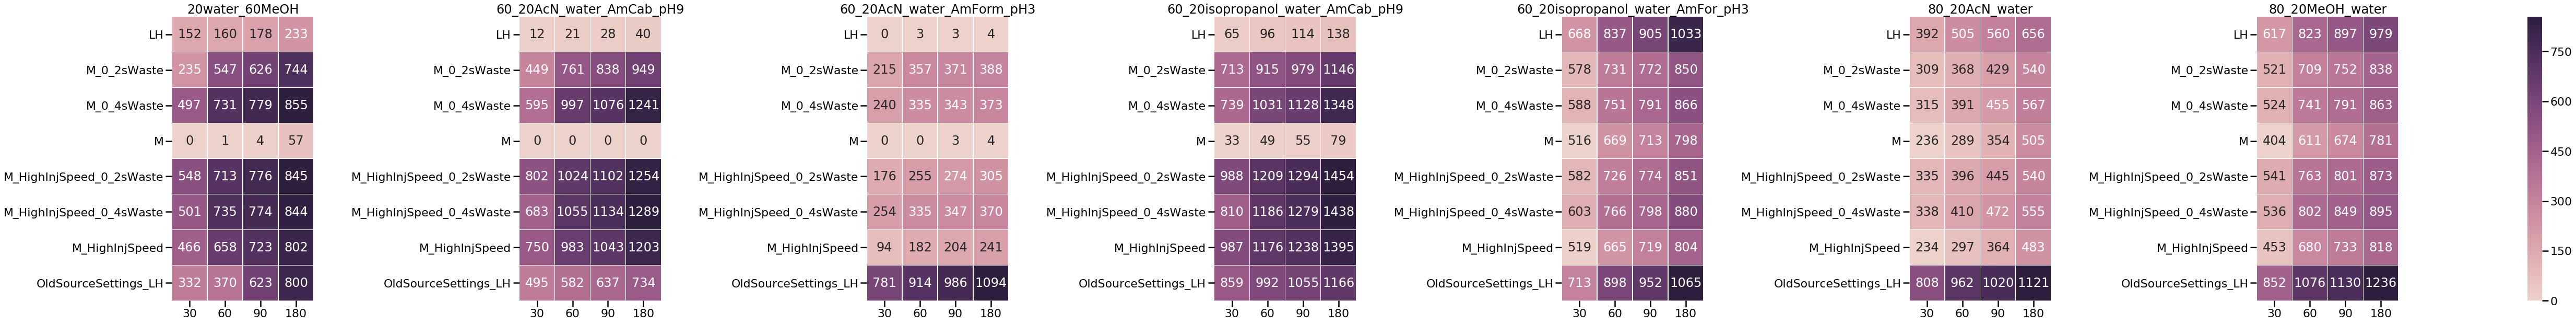

NEG


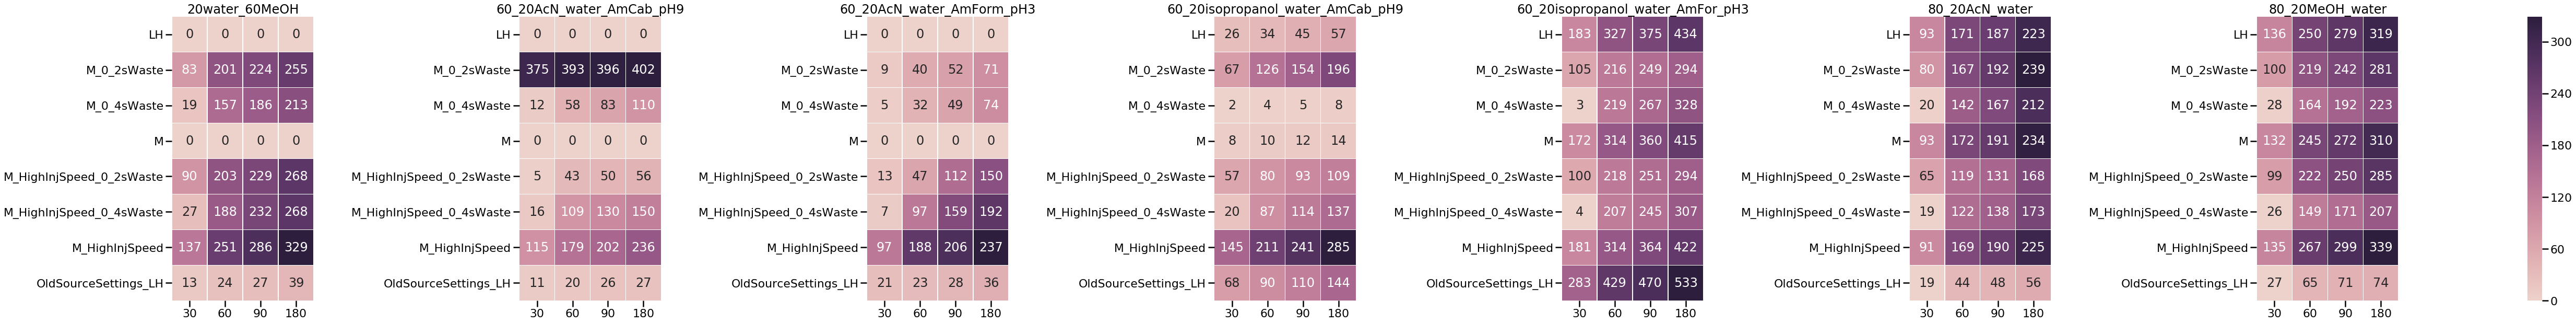

QCserum
POS


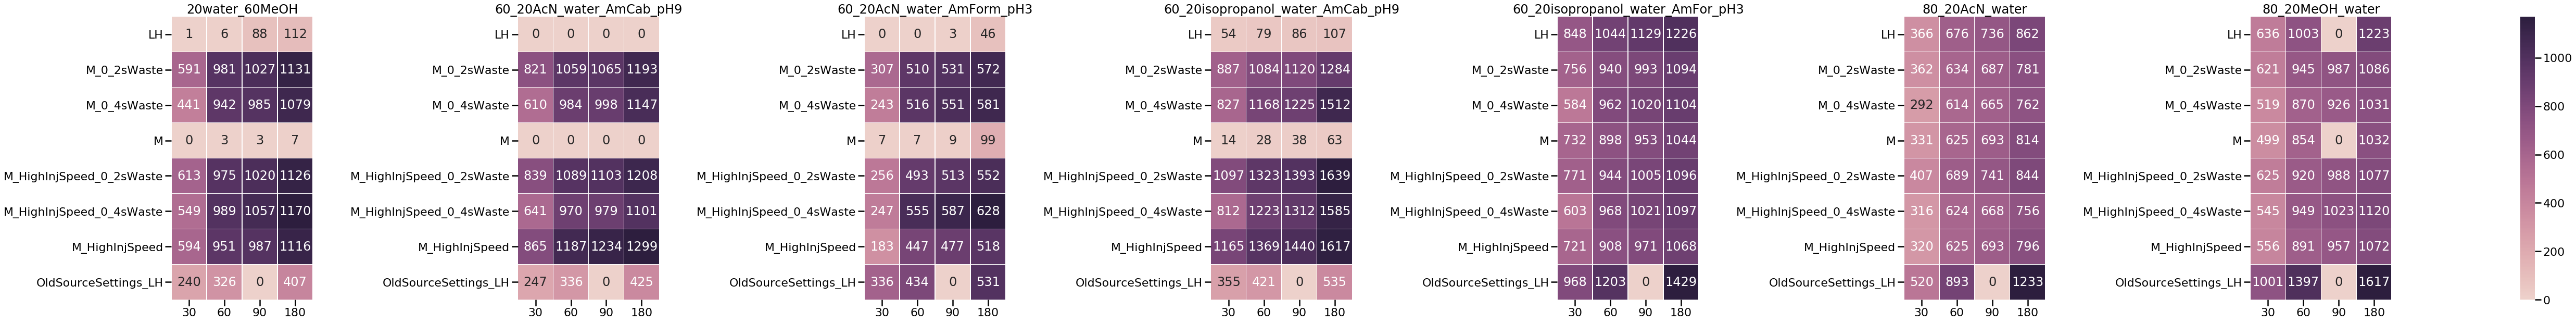

NEG


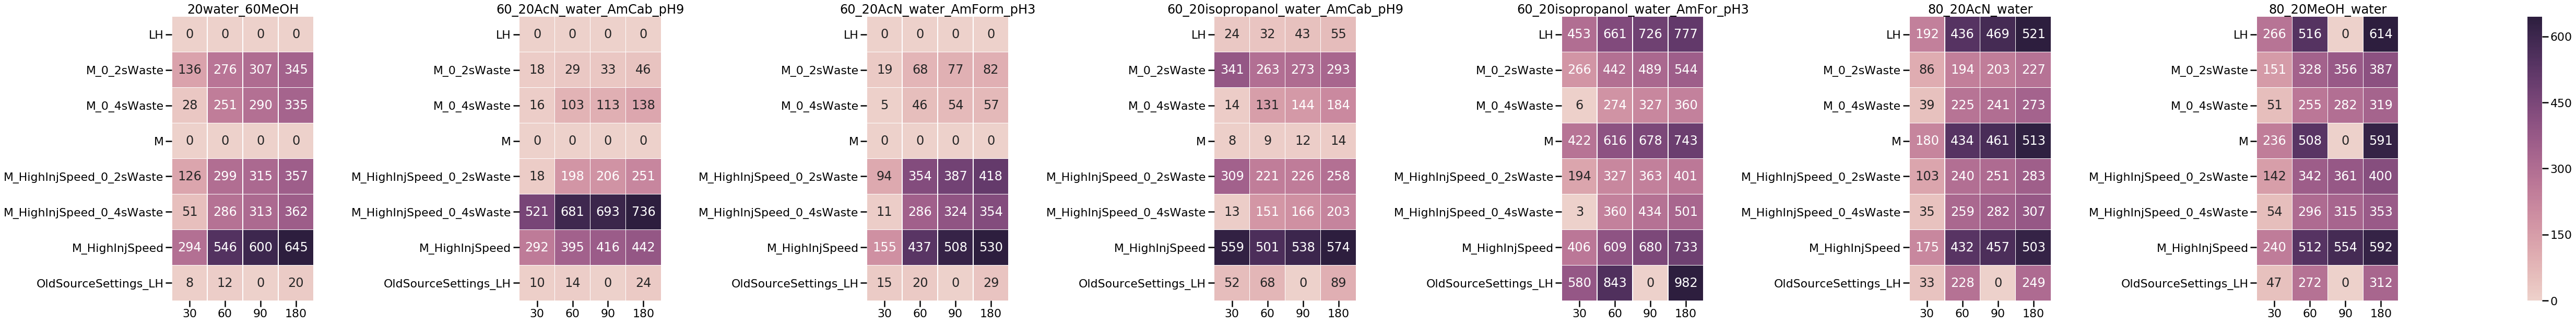

In [13]:
for sample_type in sample_types:
    print(sample_type)
    for charge in charges:
        print(charge)
        sns.set_context("poster")
        f, axs = plt.subplots(1, int((len(solvents) + 1)), figsize=(12*len(solvents), 10), gridspec_kw={'width_ratios': [10]*len(solvents) + [0.5]})
        cmap = sns.cubehelix_palette(as_cmap=True, n_colors=200)
        i = 0
        for solvent in solvents:
            df_heat = pd.DataFrame(index=methods + ['OldSourceSettings_LH'], columns=times)
            for method in methods:
                for setting in settings:
                    if setting == 'NewSourceSettings':
                        j = 0
                        for file in stats_files:
                            a = dates[0] + '_' + sample_type + '_' + setting + '_' + solvent + '_' + method + '_' + charge
                            df_heat.loc[method, times[j]] = len(file[a])
                            j += 1
                    else:
                        j = 0
                        for file in stats_files:
                            b = dates[0] + '_' + sample_type + '_' + setting + '_' + solvent + '_' + methods[0] + '_' + charge
                            df_heat.loc[(methods + ['OldSourceSettings_LH'])[len((methods + ['OldSourceSettings_LH'])) - 1], times[j]] = len(file[b])
                            j += 1
            sns.heatmap(df_heat, annot=True, fmt="d", cmap=cmap, vmax=df_heat.max().max(), vmin=df_heat.min().min(),
                square=True, linewidths=.5, cbar=(solvent=='20water_60MeOH'), cbar_ax=axs[-1], ax=axs[i])
            axs[i].set_ylim(len(methods + ['OldSourceSettings_LH']), 0)
            axs[i].set_title(f'{solvent}')
            i += 1
        plt.show()
        #f.savefig('FullDB' + '_' + sample_type + '_' + charge + '.pdf')

Blank
POS


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

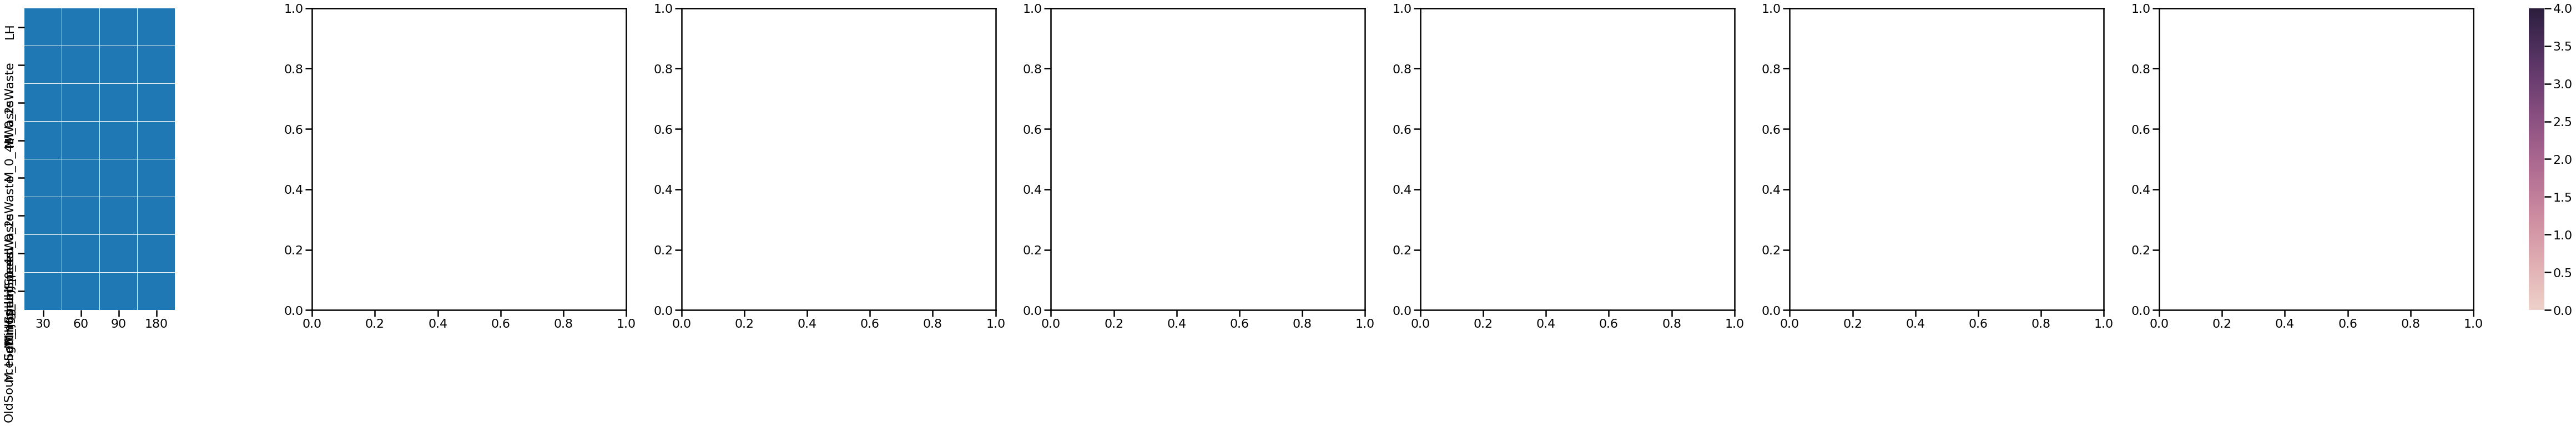

In [74]:
for sample_type in sample_types:
    print(sample_type)
    for charge in charges:
        print(charge)
        sns.set_context("poster")
        f, axs = plt.subplots(1, int((len(solvents) + 1)), figsize=(12*len(solvents), 10), gridspec_kw={'width_ratios': [10]*len(solvents) + [0.5]})
        cmap = sns.cubehelix_palette(as_cmap=True, n_colors=200)
        i = 0
        for solvent in solvents:
            df_heat = pd.DataFrame(index=methods + ['OldSourceSettings_LH'], columns=times)
            for method in methods:
                for setting in settings:
                    if setting == 'NewSourceSettings':
                        j = 0
                        for file in stats_files:
                            a = dates[0] + '_' + sample_type + '_' + setting + '_' + solvent + '_' + method + '_' + charge
                            df_heat.loc[method, times[j]] = len(file[a])
                            j += 1
                    else:
                        j = 0
                        for file in stats_files:
                            b = dates[0] + '_' + sample_type + '_' + setting + '_' + solvent + '_' + methods[0] + '_' + charge
                            df_heat.loc[(methods + ['OldSourceSettings_LH'])[len((methods + ['OldSourceSettings_LH'])) - 1], times[j]] = len(file[b])
                            j += 1
            sns.heatmap(df_heat, annot=True, fmt="d", cmap=cmap, vmax=df_heat.max().max(), vmin=df_heat.min().min(),
                square=True, linewidths=.5, cbar=(solvent=='20water_60MeOH'), cbar_ax=axs[-1], ax=axs[i])
            axs[i].set_ylim(len(methods + ['OldSourceSettings_LH']), 0)
            axs[i].set_title(f'{solvent}')
            i += 1
        plt.show()
        #f.savefig('FullDB' + '_' + sample_type + '_' + charge + '.pdf')

In [268]:
stats_files2 = copy.deepcopy(stats_files)
for file in stats_files2:
    for each in file:
        file[each]['Run'] = each

In [269]:
file_names = ['30sec', '60sec', '90sec', '180sec']

In [270]:
sample_types = ['Blank', 'QCserum']
settings = ['NewSourceSettings', 'OldSourceSettings']
solvents = ['20water_60MeOH', '60_20AcN_water_AmCab_pH9', '60_20AcN_water_AmForm_pH3',
           '60_20isopropanol_water_AmCab_pH9', '60_20isopropanol_water_AmFor_pH3',
           '80_20AcN_water', '80_20MeOH_water']
methods = ['LH', 'M_0_2sWaste', 'M_0_4sWaste', 'M', 'M_HighInjSpeed_0_2sWaste',
          'M_HighInjSpeed_0_4sWaste', 'M_HighInjSpeed']
charges = ['POS', 'NEG']
masses = ['HighMass', 'LowMass']
times = [30, 60, 90, 180]
dates = ['20200618']

Blank
POS


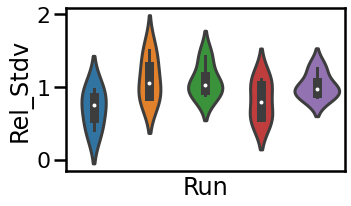

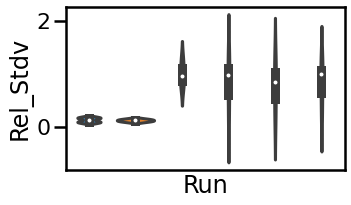

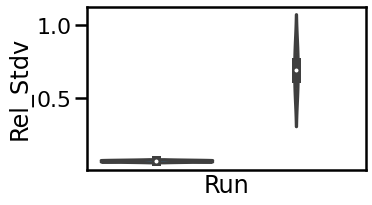

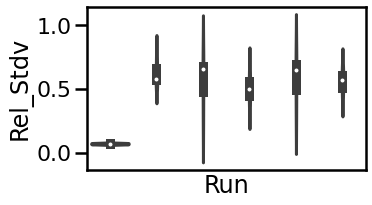

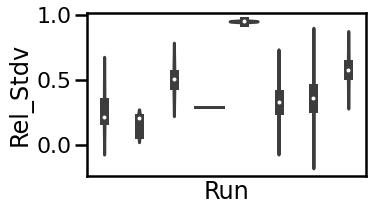

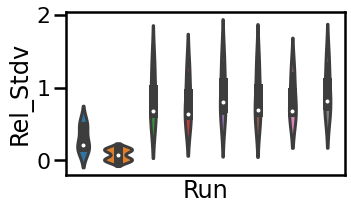

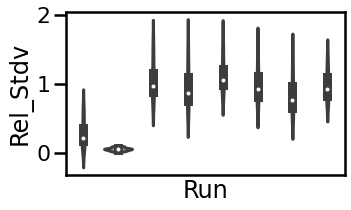

NEG


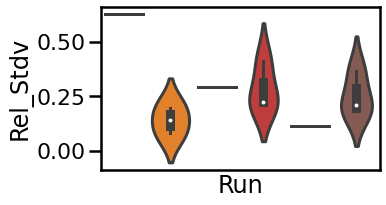

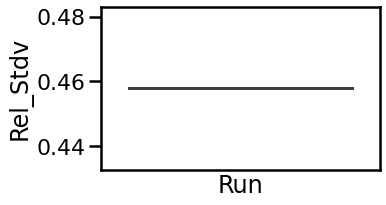

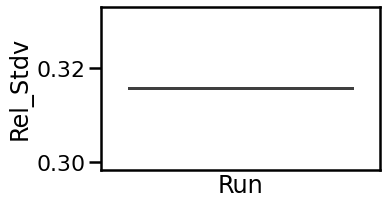

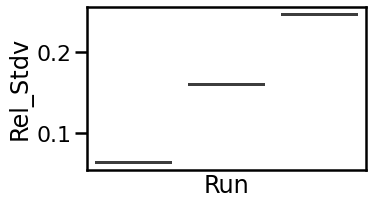

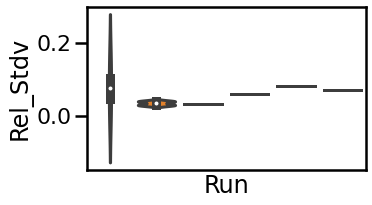

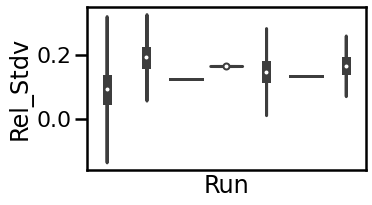

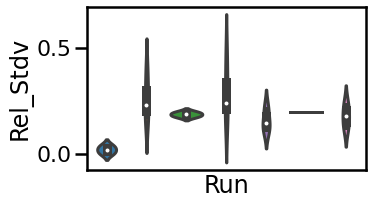

QCserum
POS


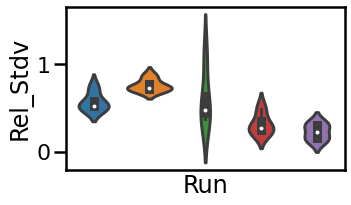

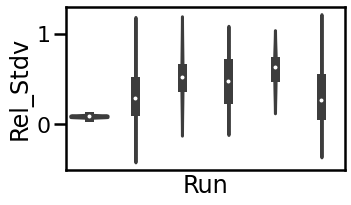

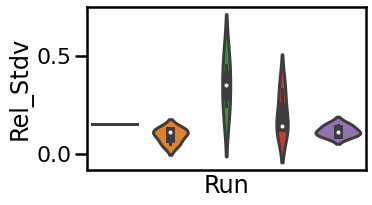

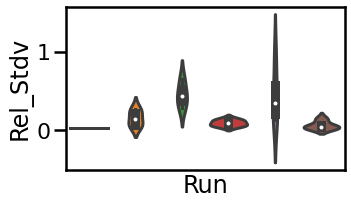

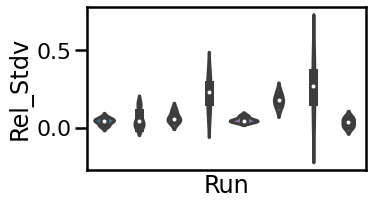

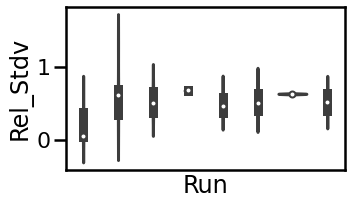

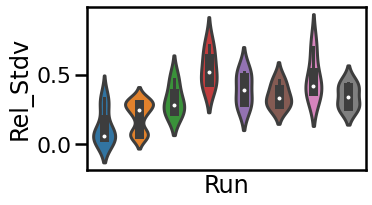

NEG


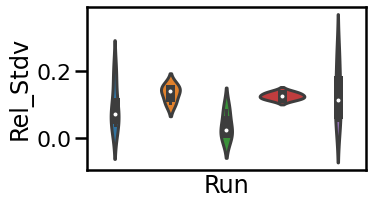

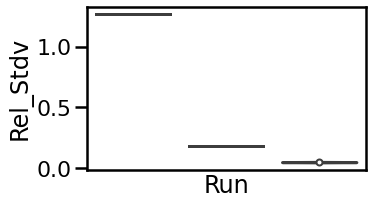

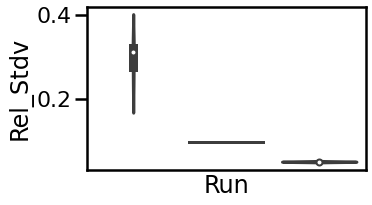

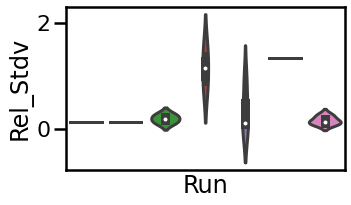

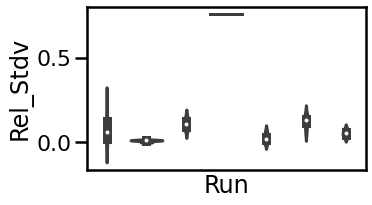

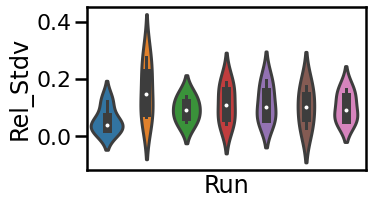

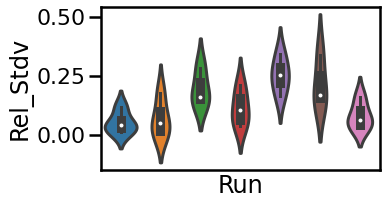

Blank
POS


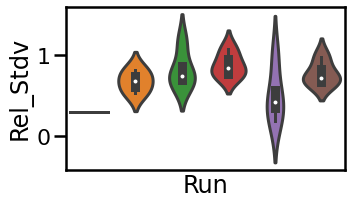

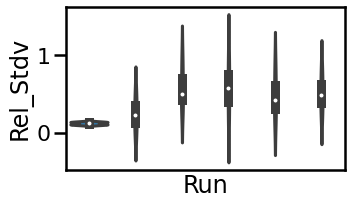

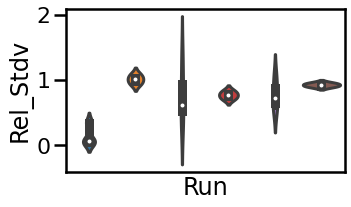

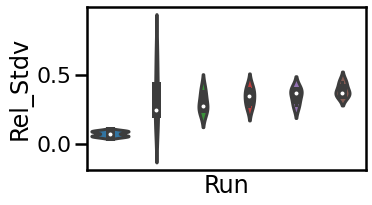

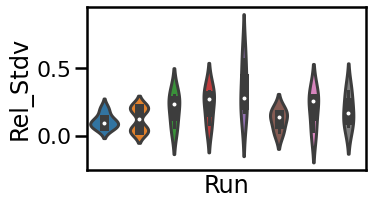

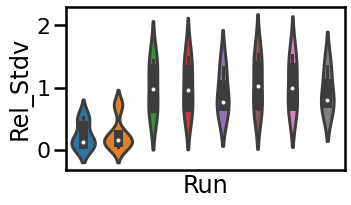

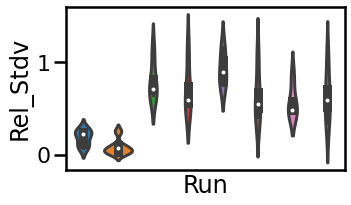

NEG


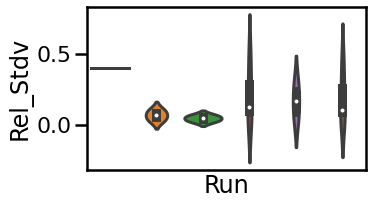

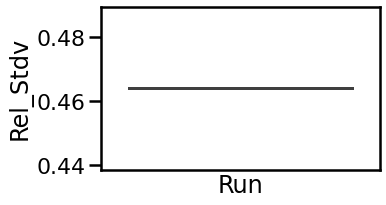

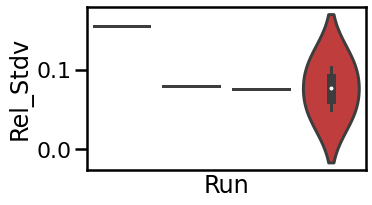

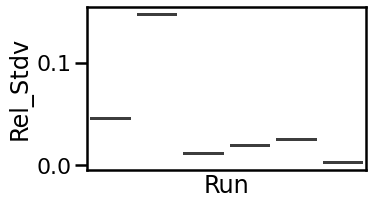

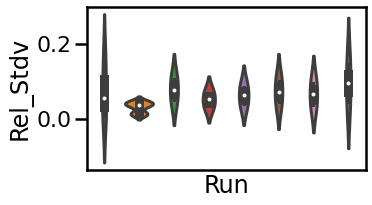

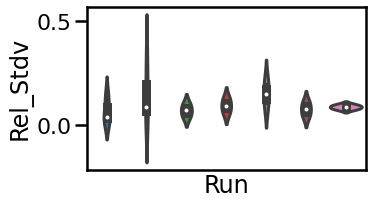

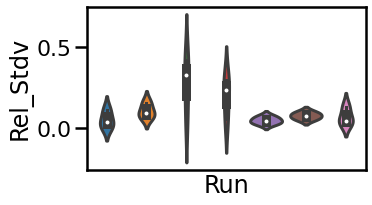

QCserum
POS


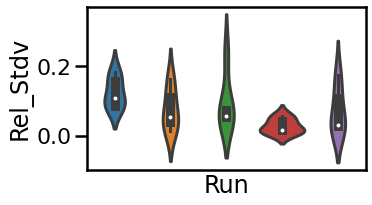

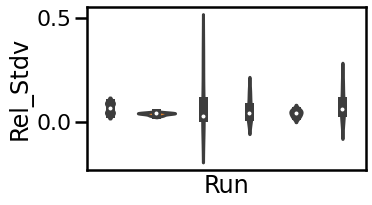

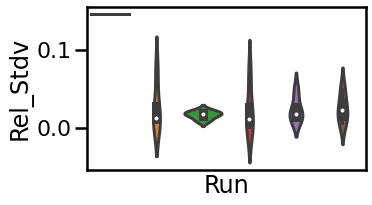

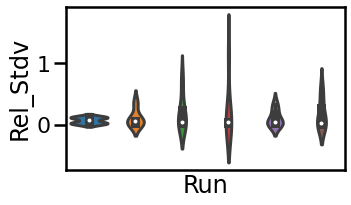

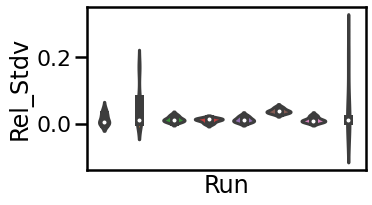

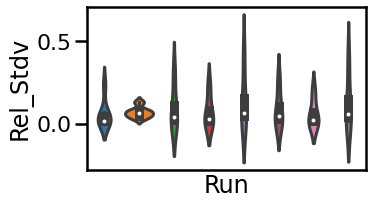

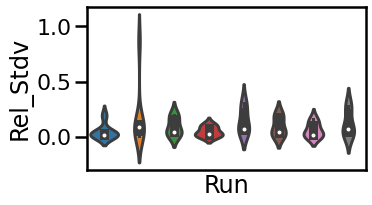

NEG


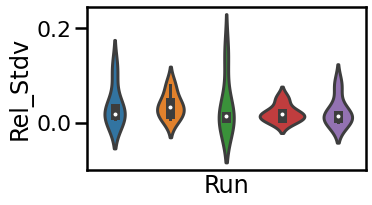

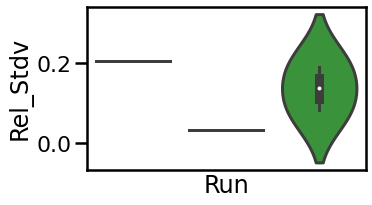

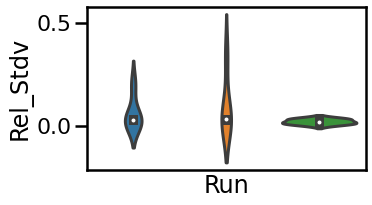

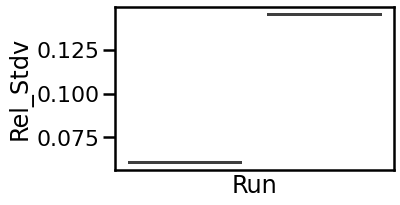

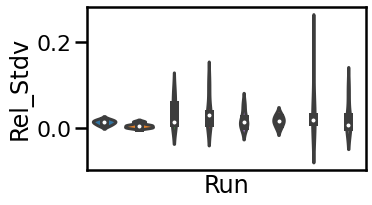

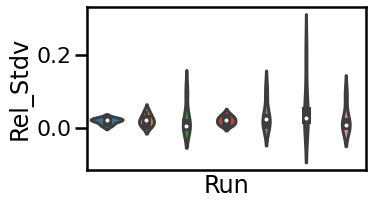

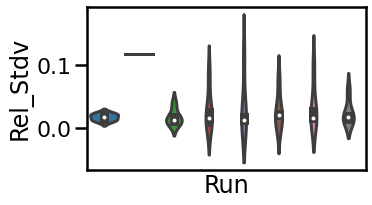

Blank
POS


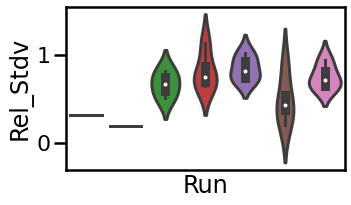

In [ ]:
for file in stats_files2:
    for sample_type in sample_types:
        print(sample_type)
        for charge in charges:
            print(charge)
            for solvent in solvents:
                results_collection = []
                sum_file = pd.concat(file)
                names_collection = []
                for name in list(sum_file.index):
                    names_collection.append(name[0])
                for method in methods:
                    for setting in settings:
                        if setting == 'NewSourceSettings':
                            run_name = dates[0] + '_' + sample_type + '_' + setting + '_' + solvent + '_' + method + '_' + charge
                        else:
                            run_name = dates[0] + '_' + sample_type + '_' + setting + '_' + solvent + '_' + methods[0] + '_' + charge
                        if run_name in names_collection:
                            run_data = sum_file.loc[run_name,:]
                            results_collection.append(run_data)
                print(solve)
                results_collection = pd.concat(results_collection)
                plt.figure(figsize=(5,3))
                sns.violinplot(x="Run", y="Rel_Stdv", data=results_collection, orient = 'v')
                plt.xticks([])
                plt.show()

In [254]:
results_collection

,Metabolite,Mean,Variance,Rel_Stdv
0,HMDB:HMDB0000122,3.455179e+05,1.953754e+10,0.404543
1,HMDB:HMDB0000182,2.541426e+06,3.577393e+12,0.744228
2,HMDB:HMDB0000641,2.605344e+06,6.397981e+12,0.970860
0,HMDB:HMDB0000122,9.829934e+06,2.211969e+14,1.513000
1,HMDB:HMDB0000182,1.094148e+06,9.479382e+11,0.889844
2,HMDB:HMDB0000289,5.952538e+05,5.290302e+11,1.221907
3,HMDB:HMDB0000641,1.254560e+06,1.113707e+12,0.841190
0,HMDB:HMDB0000122,4.916252e+07,4.888558e+15,1.422185
1,HMDB:HMDB0000182,3.416154e+06,1.129868e+13,0.983958
2,HMDB:HMDB0000289,2.280414e+06,5.874261e+12,1.062828


([], [])

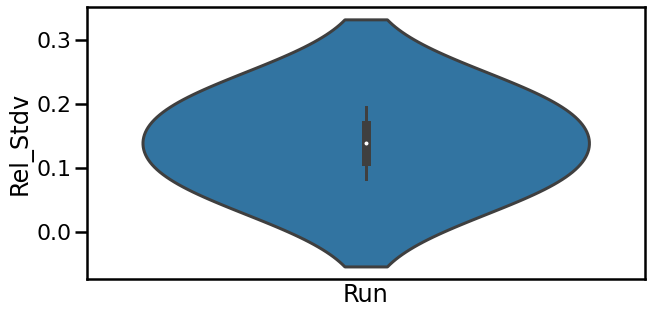

In [99]:
sum_file = pd.concat(stats_files2[0], axis=0, join='outer', ignore_index=False, keys=None,
                                          levels=None, names=None, verify_integrity=False, copy=True)
a = '20200618_Blank_NewSourceSettings_20water_60MeOH_M_0_2sWaste_NEG'
c = sum_file.loc[a,:]
plt.figure(figsize=(10,5))
sns.violinplot(x="Run", y="Rel_Stdv", data=c, orient = 'v')
plt.xticks([])

In [65]:
file_iterator = 0
for files in stats_files2:
    print(file_names[file_iterator])
    for sample_type in sample_types:
        print(sample_type)
        a = pd.concat(files, axis=0, join='outer', ignore_index=False, keys=None,
              levels=None, names=None, verify_integrity=False, copy=True)
        #for run in a['Run']:
            #if sample_type in run:
                #print(run)
                #plt.figure(figsize=(10,5))
                #sns.violinplot(x="Run", y="Rel_Stdv", data=a, orient = 'v')
                #plt.xticks([])
                #plt.show()
    file_iterator += 1

30sec
Blank
QCserum
60sec
Blank
QCserum
90sec
Blank
QCserum
180sec
Blank
QCserum


In [374]:
a = pd.concat(stats_files2[0], join='outer', ignore_index=False, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True)

In [318]:
SerumTop10 = pd.read_csv("/Users/matmat/Documents/FIA-MS/20200618_Source_Scanrange_Waste_Solvents_Adducts/traML.csv", 
                                 sep="\,", header=None, engine='python')
DB = list(SerumTop10.iloc[:,0])[1:]
Name = list(SerumTop10.iloc[:,3])[1:]
trans = {'DB': DB, 'Name': Name}

translator = pd.DataFrame(trans)

j = 0
name_list = []
for each in a['Metabolite']:
    i = 0
    for trans in translator['DB']:
        if each == trans:
            name_list.append(list(translator['Name'])[i])
        i += 1
    j += 1

([], [])

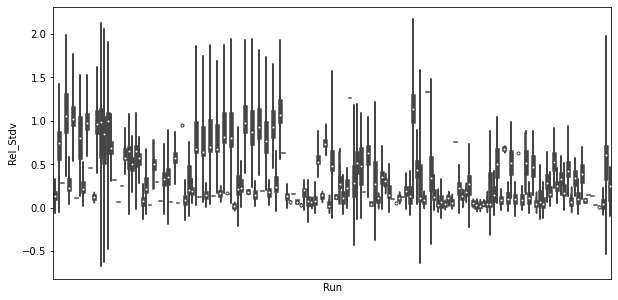

In [358]:
plt.figure(figsize=(10,5))
sns.violinplot(x="Run", y="Rel_Stdv", data=a, orient = 'v')
plt.xticks([])

([], [])

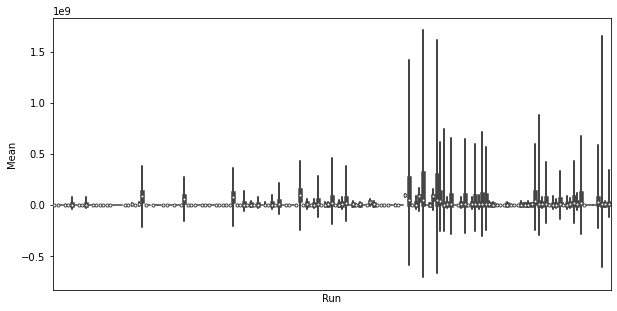

In [359]:
plt.figure(figsize=(10,5))
sns.violinplot(x="Run", y="Mean", data=a, orient = 'v')
plt.xticks([])